### Imports

In [80]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
import glob
from oak_cli.evaluation.resources.main import ResourcesCSVKeys
from oak_cli.evaluation.addons.flops.main import FLOpsExclusiveCSVKeys, EvaluationRunFLOpsProjectStage, FLOPS_STAGES_INDEX_MAP, TRAINED_MODEL_PERFORMANCE_CSV, FLOpsTrainedModelCSVKeys
from oak_cli.evaluation.common import get_csv_dir_for_scenario
from oak_cli.evaluation.types import EvaluationScenario
from oak_cli.evaluation.graph_utils import CPU_AND_MEMORY_KEYS, get_evaluation_run_duration_label, adjust_xticks
from typing import List
from pydantic import BaseModel
import pathlib

### Constants

In [81]:
csv_dir = get_csv_dir_for_scenario(EvaluationScenario.FLOPS)

# csv_dir = pathlib.Path("/home/alex/oakestra-cli/oak_cli/evaluation/addons/flops/csv/flops_evaluation_runs/")

### Settings

In [82]:
USE_MINUTES = True

### Error Handing & Checking

In [83]:
if not csv_dir.exists():
    logger.error(f"{csv_dir} does not exist yet!")
    sys.exit(1)

### Common Graph Configuration

In [84]:
csv_files = glob.glob(f'{csv_dir}/*.csv')
df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)

trained_model_df = pd.read_csv(TRAINED_MODEL_PERFORMANCE_CSV)

# NOTE: The CSV "time-since-start" values are very precise, thus they differ (slightly) between Evaluation-Runs.
# This difference leads to issues when trying to plot them in an aggregated way.
# To fix this we cast the floats to ints instead. I.e. we are looking at whole seconds - which is fine for this concrete use-case.
df[[ResourcesCSVKeys.TIME_SINCE_START.value]] = df[[ResourcesCSVKeys.TIME_SINCE_START.value]].astype(int)

df.set_index(ResourcesCSVKeys.TIME_SINCE_START.value, inplace=True)

if USE_MINUTES:
    df.index = df.index / 60

### Common Graph Styling

In [85]:
sns.set_style("whitegrid")
flops_palette = "rainbow"

# Graphs Drawing

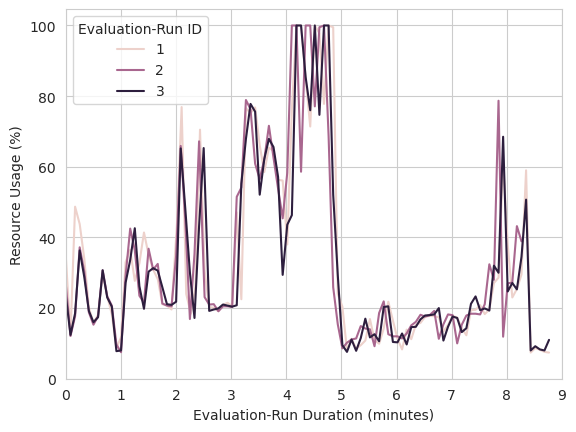

In [86]:
fig, ax = plt.subplots()

#df = df[df[ResourcesCSVKeys.EVALUATION_RUN_ID.value] != 6] 

#sns.lineplot(data=df[CPU_AND_MEMORY_KEYS])
sns.lineplot(data=df, x=ResourcesCSVKeys.TIME_SINCE_START.value, y=ResourcesCSVKeys.CPU_USAGE.value, hue=ResourcesCSVKeys.EVALUATION_RUN_ID.value)

plt.xlabel(get_evaluation_run_duration_label())
plt.ylabel("Resource Usage (%)")
plt.xlim([0, max(df.index)])
plt.ylim(0)
adjust_xticks(ax)

plt.show()

In [87]:
#sns.color_palette(palette=flops_palette, n_colors=4)
#sns.color_palette(palette="hsv", n_colors=4)
sns.color_palette(palette="tab10", n_colors=4)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)]

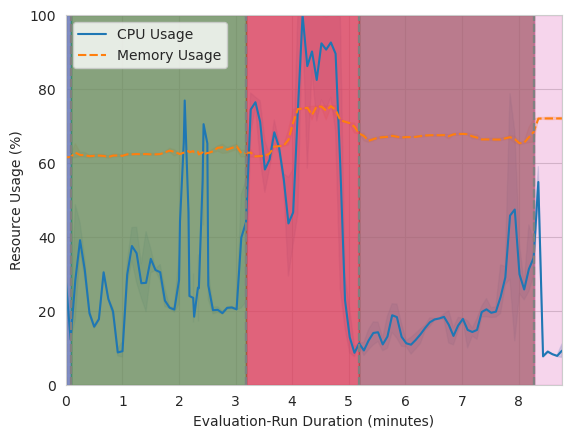

In [88]:
fig, ax = plt.subplots()

#df = df[df[ResourcesCSVKeys.EVALUATION_RUN_ID.value] == 1] 

sns.lineplot(data=df[CPU_AND_MEMORY_KEYS])

class Stage_Info(BaseModel):
    stage: EvaluationRunFLOpsProjectStage
    start: float = 0
    end: float = 0

stages: List[Stage_Info] = []
last_stage = ""
for index, row in df.iterrows():
    current_stage = EvaluationRunFLOpsProjectStage(row[FLOpsExclusiveCSVKeys.FLOPS_PROJECT_STAGE.value])

    if last_stage == "":
        last_stage = current_stage
        stages.append(Stage_Info(start=0, stage=current_stage))

    if last_stage != current_stage:
        last_stage = current_stage
        plt.axvline(x=index, color='grey', linestyle='--', ymax=100)
        _last_stage = stages[-1]
        _last_stage.end = float(index)
        next_stage = Stage_Info(start=index, stage=current_stage)
        stages.append(next_stage)

stages[-1].end = max(df.index)
for stage_info in stages:
    plt.fill_between(
        (stage_info.start,stage_info.end),
        100,
        color=sns.color_palette(palette="tab10", n_colors=len(list(FLOpsExclusiveCSVKeys.FLOPS_PROJECT_STAGE)))[FLOPS_STAGES_INDEX_MAP[stage_info.stage]],
        #alpha=0.1
        alpha=0.3
    )

plt.xlabel(get_evaluation_run_duration_label())
plt.ylabel("Resource Usage (%)")

plt.xlim([0, max(df.index)])
plt.ylim(0, 100)

plt.show()

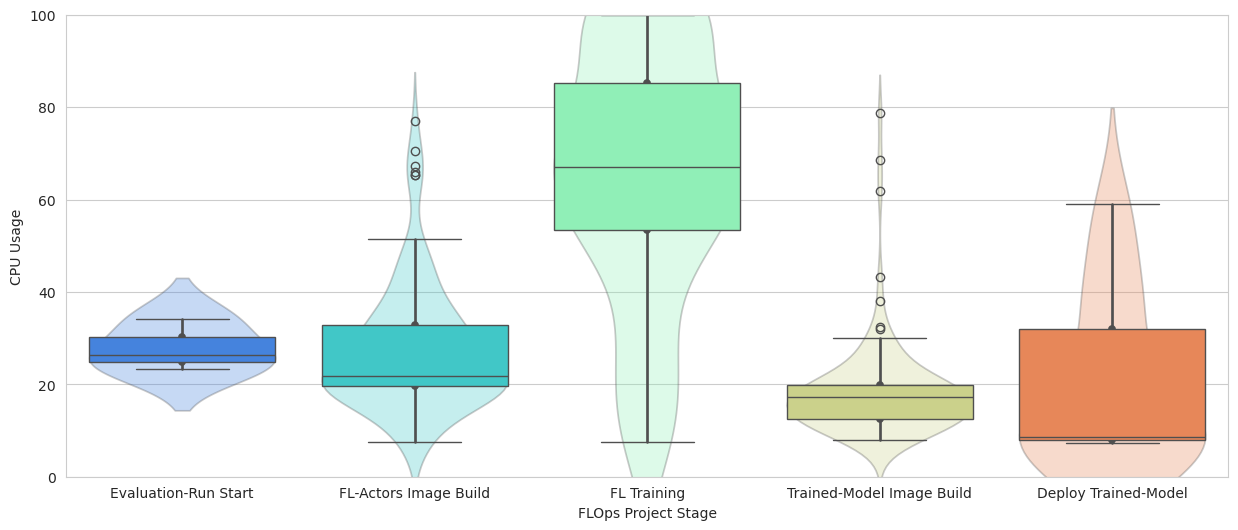

In [89]:
plt.figure(figsize=(15, 6)) 
sns.violinplot(
    x=FLOpsExclusiveCSVKeys.FLOPS_PROJECT_STAGE.value,
    y=ResourcesCSVKeys.CPU_USAGE.value,
    data=df,
    hue=FLOpsExclusiveCSVKeys.FLOPS_PROJECT_STAGE.value,
    alpha=0.3,
    palette=flops_palette,
)
sns.boxplot(
    x=FLOpsExclusiveCSVKeys.FLOPS_PROJECT_STAGE.value,
    y=ResourcesCSVKeys.CPU_USAGE.value,
    data=df,
    hue=FLOpsExclusiveCSVKeys.FLOPS_PROJECT_STAGE.value,
    palette=flops_palette,
)

plt.ylim(0, 100)
plt.show()

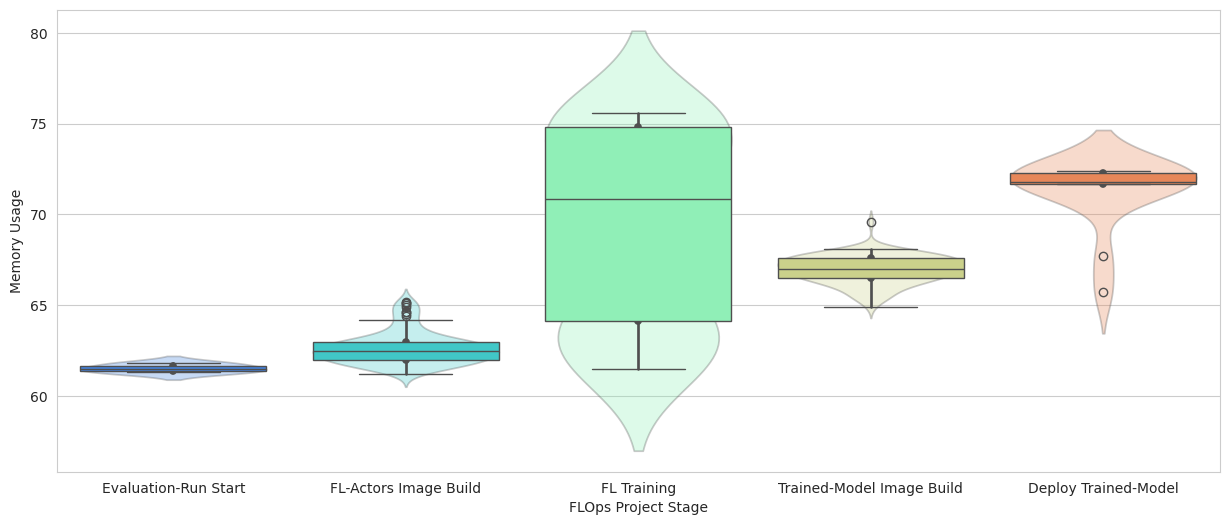

In [90]:
plt.figure(figsize=(15, 6)) 
sns.violinplot(
    x=FLOpsExclusiveCSVKeys.FLOPS_PROJECT_STAGE.value,
    y=ResourcesCSVKeys.MEMORY_USAGE.value,
    data=df,
    hue=FLOpsExclusiveCSVKeys.FLOPS_PROJECT_STAGE.value,
    alpha=0.3,
    palette=flops_palette,
)
sns.boxplot(
    x=FLOpsExclusiveCSVKeys.FLOPS_PROJECT_STAGE.value,
    y=ResourcesCSVKeys.MEMORY_USAGE.value,
    data=df,
    hue=FLOpsExclusiveCSVKeys.FLOPS_PROJECT_STAGE.value,
    palette=flops_palette,
)

#plt.ylim(0, 100)
plt.show()

/tmp/ipykernel_471193/3517686281.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=FLOpsExclusiveCSVKeys.FLOPS_PROJECT_STAGE.value, data=df, palette=flops_palette)


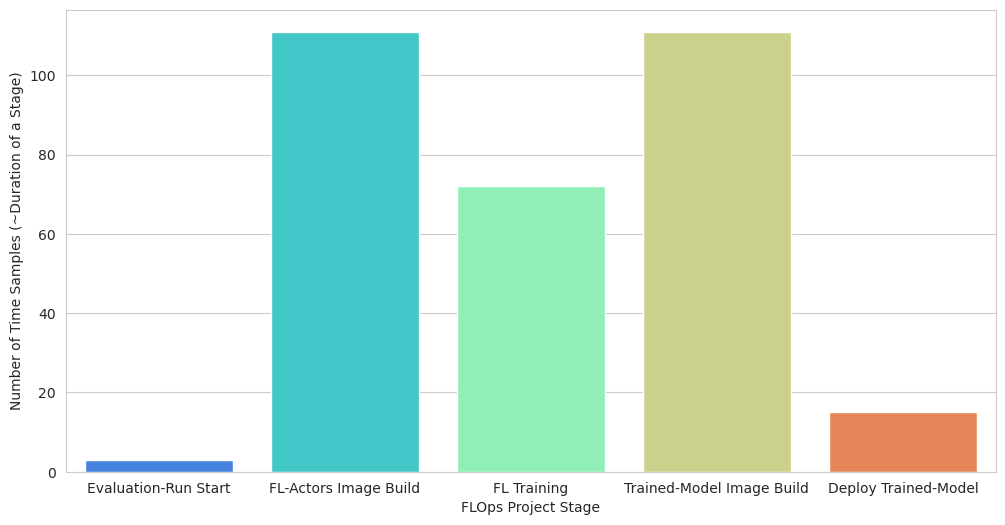

In [91]:
plt.figure(figsize=(12, 6)) 
sns.countplot(x=FLOpsExclusiveCSVKeys.FLOPS_PROJECT_STAGE.value, data=df, palette=flops_palette)

plt.ylabel("Number of Time Samples (~Duration of a Stage)")

plt.show()

### Disk Space Changes

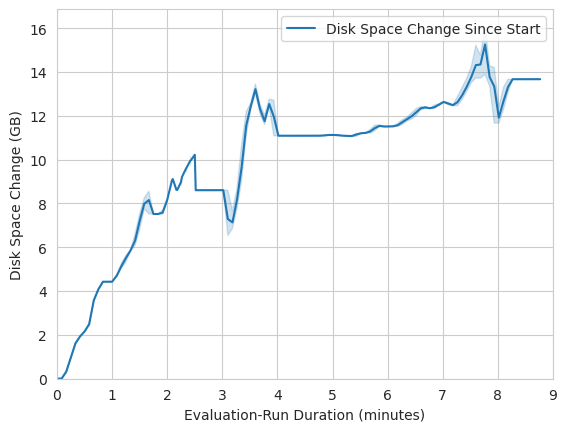

In [92]:
fig, ax = plt.subplots()

disk_space_key = ResourcesCSVKeys.DISK_SPACE_CHANGE_SINCE_START.value

# Note: Change MB to GB
df[[disk_space_key]] = df[[disk_space_key]] / 1024

sns.lineplot(data=df[[disk_space_key]])
#sns.lineplot(data=df, x=ResourcesCSVKeys.TIME_SINCE_START.value, y=disk_space_key, hue=ResourcesCSVKeys.EVALUATION_RUN_ID.value)

plt.xlabel(get_evaluation_run_duration_label())
plt.ylabel("Disk Space Change (GB)")
plt.xlim([0, max(df.index)])
plt.ylim(0)
adjust_xticks(ax)

plt.show()

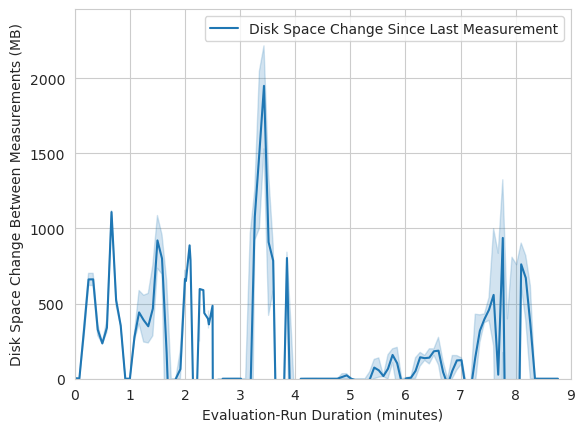

In [93]:
fig, ax = plt.subplots()

disk_space_key = ResourcesCSVKeys.DISK_SPACE_CHANGE_SINCE_LAST_MEASUREMENT.value

# Note: Change MB to GB
df[[disk_space_key]] = df[[disk_space_key]]

sns.lineplot(data=df[[disk_space_key]])

plt.xlabel(get_evaluation_run_duration_label())
plt.ylabel("Disk Space Change Between Measurements (MB)")
plt.xlim([0, max(df.index)])
plt.ylim(0)
adjust_xticks(ax)

plt.show()

### Network

### Since Start

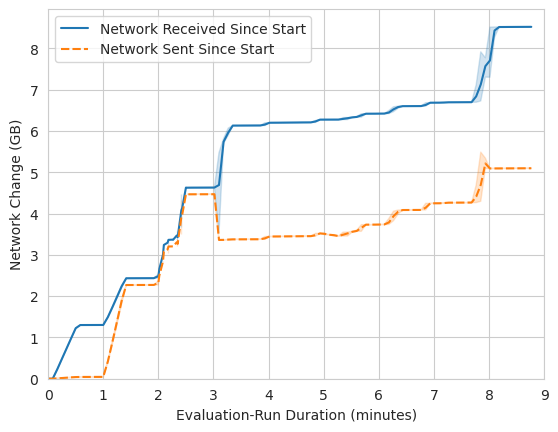

In [94]:
fig, ax = plt.subplots()

NETWORK_COMPARED_TO_START_KEYS = [ResourcesCSVKeys.NETWORK_RECEIVED_SINCE_START.value, ResourcesCSVKeys.NETWORK_SENT_SINCE_START.value]

sns.lineplot(data=df[NETWORK_COMPARED_TO_START_KEYS] / 1024)

plt.xlabel(get_evaluation_run_duration_label())
plt.ylabel("Network Change (GB)")
plt.xlim([0, max(df.index)])
plt.ylim(0)
adjust_xticks(ax)

plt.show()

### Network compared: current vs last

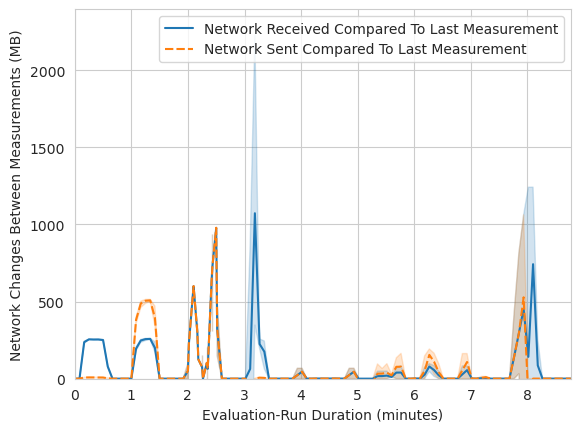

In [95]:
NETWORK_COMPARED_TO_LAST_MEASUREMENT_KEYS = [ResourcesCSVKeys.NETWORK_RECEIVED_COMPARED_TO_LAST_MEASUREMENT.value, ResourcesCSVKeys.NETWORK_SENT_COMPARED_TO_LAST_MEASUREMENT.value]

sns.lineplot(data=df[NETWORK_COMPARED_TO_LAST_MEASUREMENT_KEYS])
plt.xlabel(get_evaluation_run_duration_label())
plt.ylabel("Network Changes Between Measurements (MB)")

# Constrain axes e.g. start at 0
plt.xlim([0, max(df.index)])
plt.ylim(0)

plt.show()

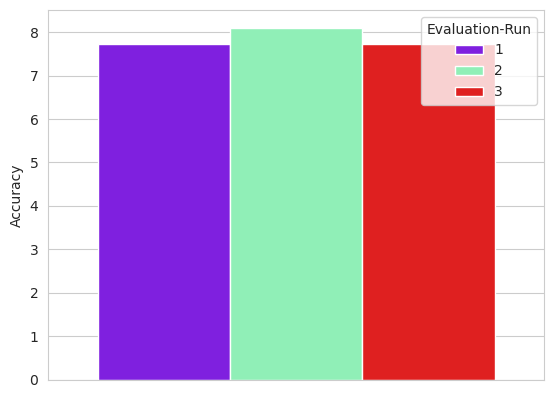

In [96]:
accuracy_key = FLOpsTrainedModelCSVKeys.ACCURACY.value
trained_model_df[accuracy_key] = trained_model_df[accuracy_key] * 100
sns.barplot(y=accuracy_key,  data=trained_model_df, palette=flops_palette, hue=FLOpsTrainedModelCSVKeys.EVALUATION_RUN.value)

plt.ylabel("Accuracy (%)")
plt.show()

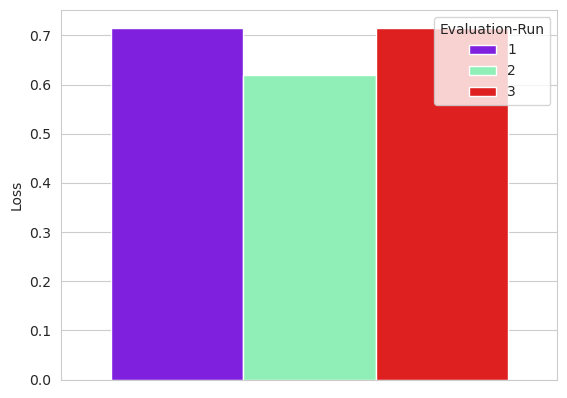

In [97]:

sns.barplot(y=FLOpsTrainedModelCSVKeys.LOSS.value,  data=trained_model_df, palette=flops_palette, hue=FLOpsTrainedModelCSVKeys.EVALUATION_RUN.value)
plt.show()